In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

import sys
sys.argv = ['GPT_eval_multi.py']
import options.option_transformer as option_trans
args = option_trans.get_args_parser()

args.dataname = 't2m'
args.resume_pth = 'pretrained/VQVAE/net_last.pth'
args.resume_trans = 'pretrained/VQTransformer_corruption05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')


from utils.paramUtil import t2m_kinematic_chain
from IPython.display import HTML
import base64


In [3]:
from utils.skeleton import Skeleton
from utils.paramUtil import *
import visualization.plot_3d_global as plot_3d

skeleton = Skeleton(offset=torch.from_numpy(t2m_raw_offsets), 
                    kinematic_tree=t2m_kinematic_chain,
                    device='cuda')
skeleton.set_offset(torch.from_numpy(t2m_raw_offsets))

In [ ]:
mean = np.load('/home/tuan/tdngo/motion_ws/deep-motion-editing/retargeting/datasets/Mixamo/mean_var/SportyGranny_mean.npy')
print(mean)

In [45]:

## load clip model and datasets
# clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda')) 
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False, download_root='./pretrained/CLIP')  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False



In [46]:
net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)


trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                embed_dim=1024, 
                                clip_dim=args.clip_dim, 
                                block_size=args.block_size, 
                                num_layers=9, 
                                n_head=16, 
                                drop_out_rate=args.drop_out_rate, 
                                fc_rate=args.ff_rate)

In [47]:


print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

print ('loading transformer checkpoint from {}'.format(args.resume_trans))
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder.eval()
trans_encoder.cuda()

mean = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

loading checkpoint from pretrained/VQVAE/net_last.pth
loading transformer checkpoint from pretrained/VQTransformer_corruption05/net_best_fid.pth



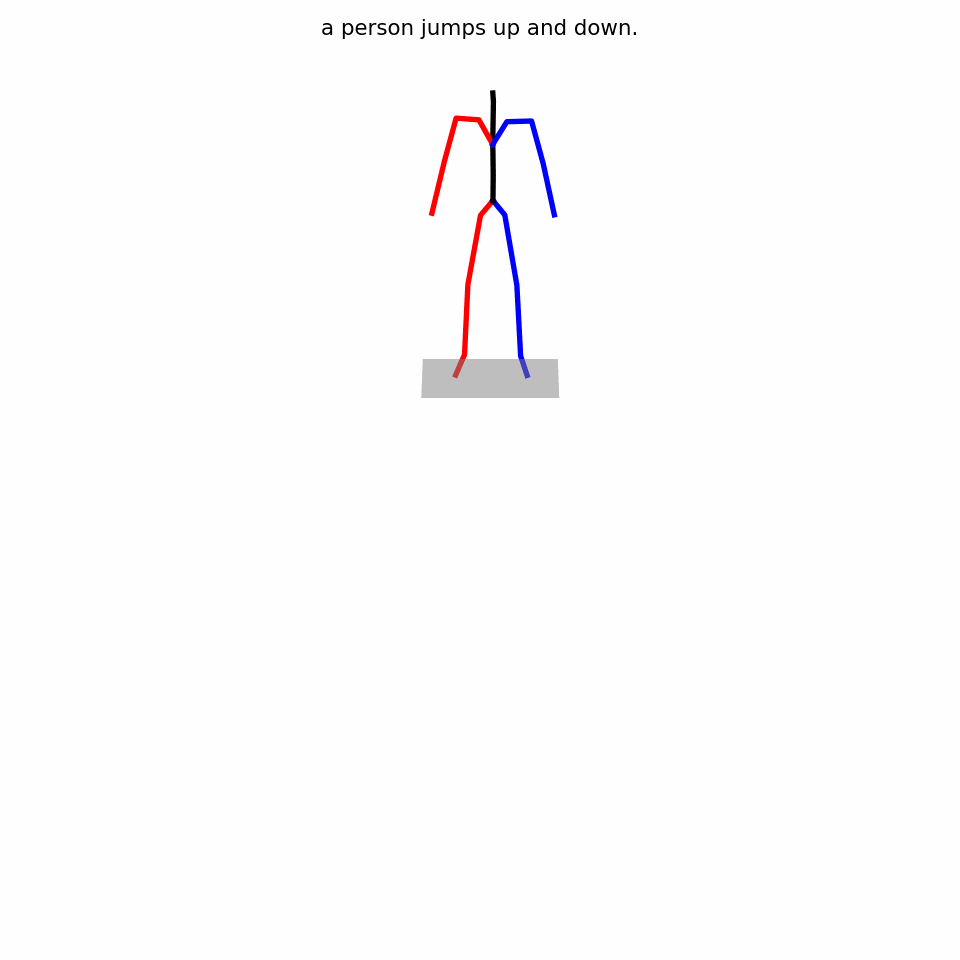

In [55]:
# clip_text = ["a person is in T pose"]
# clip_text = ["a man kicks both legs"]

# clip_text = ["a person is throwing a ball, catches it back and then throw it again and catch it again"]
# clip_text = ["a man is squatting while bringing an object to his face"]
clip_text = ["a person jumps up and down."]

# clip_text = ["a man steps forward and does a handstand."]
# clip_text = ["a person slightly crouches down and walks forward then back, then around slowly."]
# clip_text = ["a person jogs in place, slowly at first, then increases speed. they then back up and squat down."]
# clip_text = ["A man rises from the ground, walks in a circle and sits back down on the ground."]

text = clip.tokenize(clip_text, truncate=True).cuda()
feat_clip_text = clip_model.encode_text(text).float()
index_motion = trans_encoder.sample(feat_clip_text[0:1], False)
pred_pose = net.forward_decoder(index_motion)

from utils.motion_process import recover_from_ric, recover_from_rot

# pred_xyz = recover_from_rot((pred_pose*std+mean).float(), 22, skeleton)
# pred_xyz = pred_xyz.reshape(1, -1, 22, 3)
# pose_xyz = pose_xyz / 6.0

pred_xyz_ric = recover_from_ric((pred_pose*std+mean).float(), 22)
pred_xyz_ric = pred_xyz_ric.reshape(1, -1, 22, 3)

# xyz *= 100.0

# h = xyz[0,0,-1,1] - xyz[0,0,10,1]
# print(h)
# xyz[:, :, [3,6,9], 1] -= 0.5

# np.save('./results/debug_t2m/2.npy', xyz.detach().cpu().numpy())

# import visualization.plot_3d_global as plot_3d
pose_vis = plot_3d.draw_to_batch(pred_xyz_ric.detach().cpu().numpy(),clip_text, ['./results/debug_t2m_gpt/2.gif'])

b64 = base64.b64encode(open('./results/debug_t2m_gpt/2.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [15]:
# print(pred_xyz.shape)

bone_lengths = torch.sum((pred_xyz[0, :, 7, :] - pred_xyz[0, :, 10, :])**2, axis=-1)


bone_lengths_ric = torch.sum((pred_xyz_ric[0, :, 7, :] - pred_xyz_ric[0, :, 10, :])**2, axis=-1)

print(bone_lengths, bone_lengths_ric)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0', grad_fn=<SumBackward1>) tensor([0.0200, 0.0199, 0.0199, 0.0200, 0.0203, 0.0204, 0.0202, 0.0203, 0.0204,
        0.0203, 0.0204, 0.0211, 0.0214, 0.0218, 0.0215, 0.0206, 0.0209, 0.0205,
        0.0207, 0.0213, 0.0212, 0.0205, 0.0193, 0.0196, 0.0194, 0.0208, 0.0207,
        0.0238, 0.0222, 0.0223, 0.0229, 0.0209, 0.0214, 0.0205, 0.0216, 0.0218,
        0.0205, 0.0210, 0.0210, 0.0212, 0.0215, 0.0221, 0.0214, 0.0214, 0.0214,
        0.0215, 0.0212, 0.0210, 0.0211, 0.0213, 0.0211


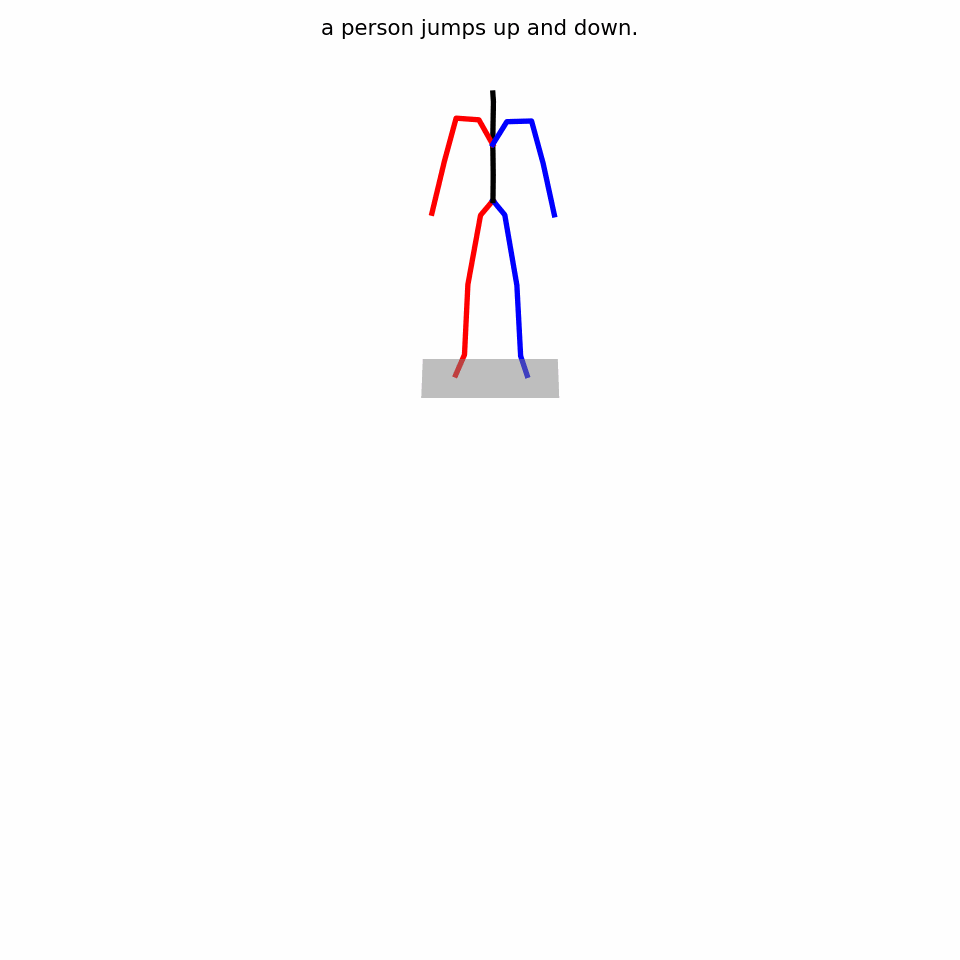

In [12]:
from IPython.display import HTML
import base64
b64 = base64.b64encode(open('./results/debug_t2m/2.gif','rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))